# Training the model

# Featurization

In [1]:
import pandas as pd
from matminer.featurizers.base import MultipleFeaturizer
from matminer.featurizers import composition as cf
from matminer.featurizers.conversions import StrToComposition


/home/gengzi/miniconda3/envs/actinide/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv("./data/targets.csv")

In [3]:
data = StrToComposition(target_col_id='composition').featurize_dataframe(data, 'formula')
feature_calculators = MultipleFeaturizer([cf.Stoichiometry(), cf.ElementProperty.from_preset("magpie"),
                                          cf.ValenceOrbital(props=['avg']), cf.IonProperty(fast=True)])
feature_labels = feature_calculators.feature_labels()
data = feature_calculators.featurize_dataframe(data, col_id='composition')
feature_labels.append('Ef')
data = data[feature_labels]

StrToComposition: 100%|██████████| 62204/62204 [00:13<00:00, 4751.83it/s]

MultipleFeaturizer: 100%|██████████| 62204/62204 [01:18<00:00, 797.03it/s]



In [4]:
data.columns

Index(['0-norm', '2-norm', '3-norm', '5-norm', '7-norm', '10-norm',
       'MagpieData minimum Number', 'MagpieData maximum Number',
       'MagpieData range Number', 'MagpieData mean Number',
       ...
       'MagpieData avg_dev SpaceGroupNumber',
       'MagpieData mode SpaceGroupNumber', 'avg s valence electrons',
       'avg p valence electrons', 'avg d valence electrons',
       'avg f valence electrons', 'compound possible', 'max ionic char',
       'avg ionic char', 'Ef'],
      dtype='object', length=146)

# Training model

## Regression for dataset containing all data

In [5]:
from sklearn import metrics
from sklearn.model_selection import cross_validate, train_test_split
import scikitplot as skplt
from sklearn.ensemble import RandomForestRegressor
from qin_plot.figures import act_pred
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.utils import shuffle
from matplotlib import pyplot as plt
RNG_SEED = 42

### Data preprocessing

In [12]:
X = data.iloc[:, :-1].to_numpy()
y = data["Ef"].to_numpy()
minmax_scaler = MinMaxScaler()
X = minmax_scaler.fit_transform(X)
X, y = shuffle(X, y, random_state=RNG_SEED)
print(X.shape, y.shape)

(62204, 145) (62204,)


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=RNG_SEED) 
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(49763, 145) (12441, 145)
(49763,) (12441,)


### Training

In [14]:
rf_model = RandomForestRegressor(n_estimators=40, n_jobs=-1, random_state=RNG_SEED)
rf_model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=40, n_jobs=-1, random_state=42)

Random Forest:
R2:  0.9426741014176369
MSE:  0.039395251978642146
CV:  {'fit_time': array([12.2408638 , 12.77574635,  9.50535941, 12.61478138, 12.78750062]), 'score_time': array([0.2396512 , 0.07455683, 1.26379538, 0.06339908, 0.07182908]), 'test_neg_mean_squared_error': array([-0.04007743, -0.04057353, -0.04431241, -0.03924055, -0.03861357]), 'test_r2': array([0.93917329, 0.94123646, 0.93197969, 0.94105177, 0.94272205])}


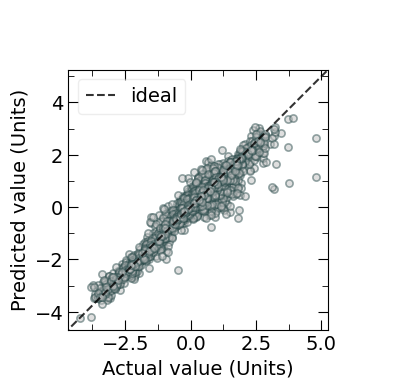

In [15]:
print("Random Forest:")
y_pred = rf_model.predict(X_test)
print('R2: ', rf_model.score(X_test, y_test))  # sklearnrint("MSE: ", mean_squared_error(y_test, model.predict(X_test))) # mse
print("MSE: ", metrics.mean_squared_error(y_test, y_pred))
print("CV: ", cross_validate(rf_model, X, y, cv=5, scoring=('neg_mean_squared_error', 'r2'), n_jobs=-1))  # CV
act_pred(y_test, rf_model.predict(X_test),  x_hist=False, y_hist=False)
#skplt.estimators.plot_feature_importances(rf_model2, feature_names=data.columns[:-1], max_num_features=10, x_tick_rotation=45)
plt.show()

In [20]:
nn_model = MLPRegressor(hidden_layer_sizes=(100, 200, 200, 100), random_state=RNG_SEED)
nn_model.fit(X_train, y_train)

MLPRegressor(hidden_layer_sizes=(100, 200, 200, 100), random_state=42)

Neural Network:
R2:  0.9418059634448885
MSE:  0.039991849939326723
CV:  {'fit_time': array([1111.14271998,  781.61149812,  208.61748552,  950.609025  ,
        326.66559935]), 'score_time': array([1.5780015 , 1.48038507, 0.71727633, 1.50066805, 0.89995074]), 'test_neg_mean_squared_error': array([-0.04715646, -0.04253909, -0.04368556, -0.04446413, -0.04318693]), 'test_r2': array([0.92842923, 0.9383897 , 0.93294191, 0.93320475, 0.93593811])}


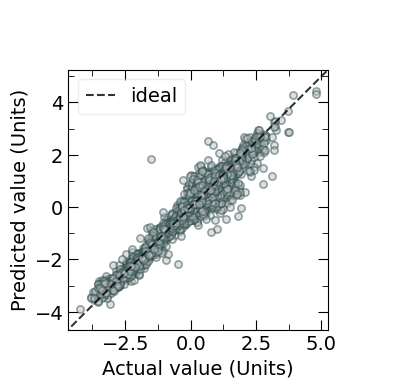

In [21]:
print("Neural Network:")
y_pred = nn_model.predict(X_test)
print('R2: ', nn_model.score(X_test, y_test))  # sklearnrint("MSE: ", mean_squared_error(y_test, model.predict(X_test))) # mse
print("MSE: ", metrics.mean_squared_error(y_test, y_pred))
print("CV: ", cross_validate(nn_model, X, y, cv=5, scoring=('neg_mean_squared_error', 'r2'), n_jobs=-1))  # CV
act_pred(y_test, nn_model.predict(X_test),  x_hist=False, y_hist=False)
#skplt.estimators.plot_feature_importances(rf_model2, feature_names=data.columns[:-1], max_num_features=10, x_tick_rotation=45)
plt.show()

## Classification for dataset containing all data

In [23]:
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_validate, train_test_split
import scikitplot as skplt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.utils import shuffle
RNG_SEED = 42
from matplotlib import pyplot as plt

### Data preprocessing

In [24]:
X = data.iloc[:, :-1].to_numpy()
y = data["Ef"].to_numpy()
minmax_scaler = MinMaxScaler()
X = minmax_scaler.fit_transform(X)
y = np.where(y < 0, 1, 0)
X, y = shuffle(X, y, random_state=RNG_SEED)
print(X.shape, y.shape)

(62204, 145) (62204,)


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=RNG_SEED) 
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(49763, 145) (12441, 145)
(49763,) (12441,)


### Training

In [26]:
rf_model = RandomForestClassifier(n_estimators=40, n_jobs=-1, random_state=RNG_SEED)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=40, n_jobs=-1, random_state=42)

Random Forest:
Accuracy:  0.9509685716582268
AUC:  0.989382027788225
f1:  0.9031130876747141
CV:  {'fit_time': array([0.4342556 , 0.85662794, 0.48796415, 0.68530965, 0.81305742]), 'score_time': array([0.07610655, 0.08481479, 0.33789635, 0.15240026, 0.08240271]), 'test_accuracy': array([0.95024516, 0.94847681, 0.95177237, 0.94791415, 0.95120579]), 'test_f1': array([0.90110241, 0.89862407, 0.90387696, 0.8972733 , 0.90387965]), 'test_roc_auc': array([0.98913673, 0.98846728, 0.9885502 , 0.98791654, 0.98891455])}


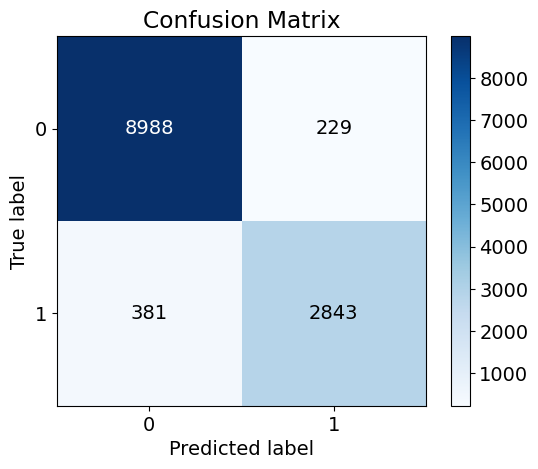

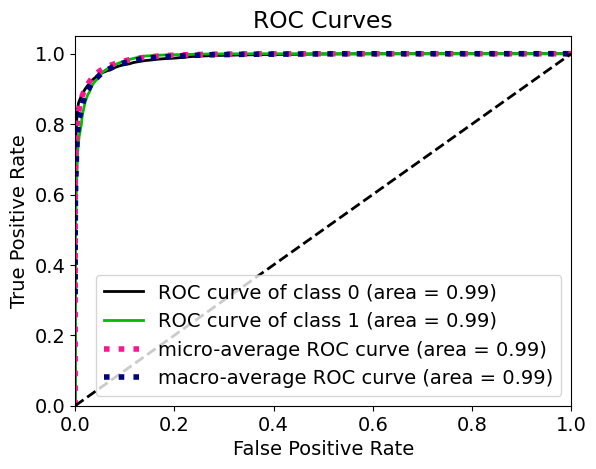

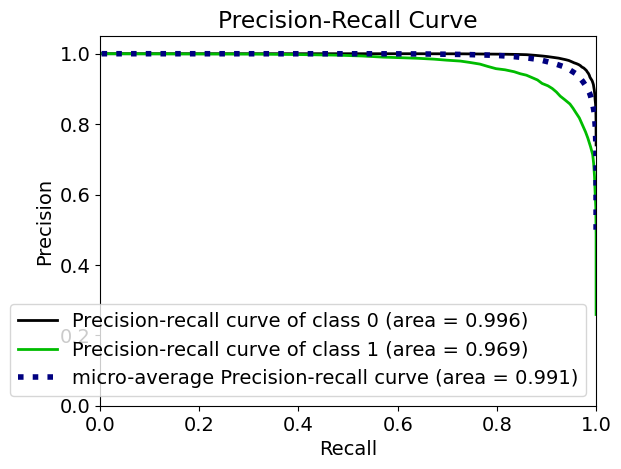

In [27]:
print("Random Forest:")
y_probas = rf_model.predict_proba(X_test)
y_pred = rf_model.predict(X_test)
print('Accuracy: ', rf_model.score(X_test, y_test))  # Accuracy
print("AUC: ", metrics.roc_auc_score(y_test,y_probas[:, 1]))
print("f1: ", metrics.f1_score(y_test, y_pred))
print("CV: ", cross_validate(rf_model, X, y, cv=5, scoring=('accuracy', 'f1', "roc_auc"), n_jobs=-1))  # Accuracy_CV

skplt.metrics.plot_confusion_matrix(y_test, y_pred)
skplt.metrics.plot_roc(y_test, y_probas)
skplt.metrics.plot_precision_recall(y_test, y_probas)
# skplt.estimators.plot_feature_importances(model, feature_names=data.columns[:-1], max_num_features=10, x_tick_rotation=45)
plt.show()


In [28]:
nn_model = MLPClassifier(hidden_layer_sizes=(100, 200, 200, 100), random_state=RNG_SEED)
nn_model.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(100, 200, 200, 100), random_state=42)

Neural Network:
Accuracy:  0.9434129089301503
AUC:  0.986285456451034
f1:  0.8897933625547901
CV:  {'fit_time': array([0.39408159, 0.75713181, 0.81179428, 0.75688004, 0.88851428]), 'score_time': array([0.07862067, 0.10858607, 0.0825448 , 0.09950995, 0.08467889]), 'test_accuracy': array([0.95024516, 0.94847681, 0.95177237, 0.94791415, 0.95120579]), 'test_f1': array([0.90110241, 0.89862407, 0.90387696, 0.8972733 , 0.90387965]), 'test_roc_auc': array([0.98913673, 0.98846728, 0.9885502 , 0.98791654, 0.98891455])}


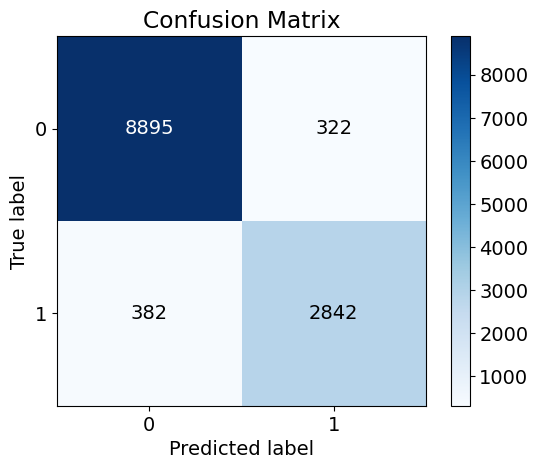

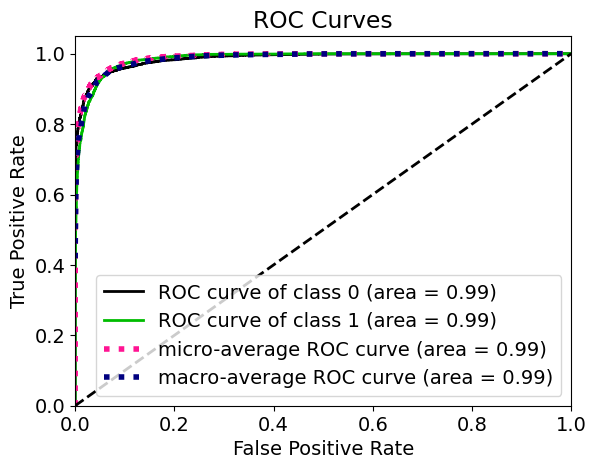

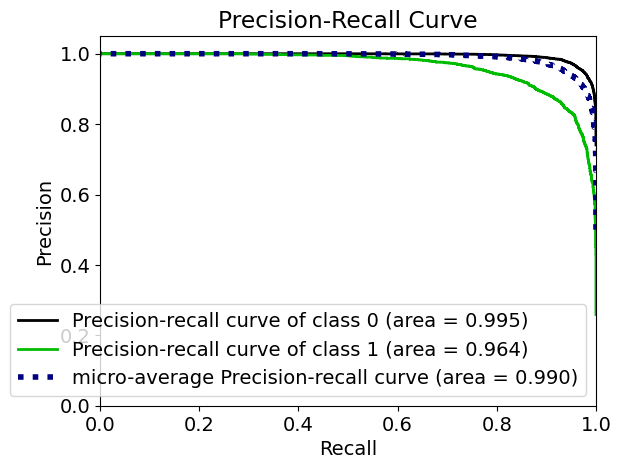

In [29]:
print("Neural Network:")
y_probas = nn_model.predict_proba(X_test)
y_pred = nn_model.predict(X_test)
print('Accuracy: ', nn_model.score(X_test, y_test))  # Accuracy
print("AUC: ", metrics.roc_auc_score(y_test,y_probas[:, 1]))
print("f1: ", metrics.f1_score(y_test, y_pred))
print("CV: ", cross_validate(rf_model, X, y, cv=5, scoring=('accuracy', 'f1', "roc_auc"), n_jobs=-1))  # Accuracy_CV

skplt.metrics.plot_confusion_matrix(y_test, y_pred)
skplt.metrics.plot_roc(y_test, y_probas)
skplt.metrics.plot_precision_recall(y_test, y_probas)
# skplt.estimators.plot_feature_importances(model, feature_names=data.columns[:-1], max_num_features=10, x_tick_rotation=45)
plt.show()

## Regression for subset with Ef < 0 eV/atom

In [30]:
from sklearn import metrics
from sklearn.model_selection import cross_validate, train_test_split
import scikitplot as skplt
from sklearn.ensemble import RandomForestRegressor
from qin_plot.figures import act_pred
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.utils import shuffle
RNG_SEED = 42
from matplotlib import pyplot as plt

### Data preprocessing

In [31]:
data1 = data[data['Ef']<0]
X = data1.iloc[:, :-1].to_numpy()
y = data1["Ef"].to_numpy()
minmax_scaler_X = MinMaxScaler()
X = minmax_scaler_X.fit_transform(X)
X, y = shuffle(X, y, random_state=RNG_SEED)
print(X.shape, y.shape)

(16051, 145) (16051,)


In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=RNG_SEED)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(12840, 145) (3211, 145)
(12840,) (3211,)


In [33]:
rf_model2 = RandomForestRegressor(n_estimators=40, n_jobs=-1, random_state=RNG_SEED)
rf_model2.fit(X_train, y_train)

RandomForestRegressor(n_estimators=40, n_jobs=-1, random_state=42)

Random Forest:
R2:  0.9758621193743033
MSE:  0.01912158077832673
CV:  {'fit_time': array([1.25756264, 2.7155025 , 2.21102476, 2.36201644, 1.78519678]), 'score_time': array([0.36406016, 0.0218854 , 0.03730607, 0.03129125, 0.28569388]), 'test_neg_mean_squared_error': array([-0.01906843, -0.02016161, -0.01867268, -0.02151751, -0.01868873]), 'test_r2': array([0.97481803, 0.97288743, 0.97648953, 0.97237736, 0.97522761])}


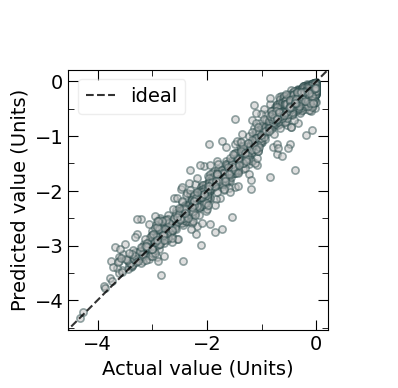

In [34]:
print("Random Forest:")
y_pred = rf_model2.predict(X_test)
print('R2: ', rf_model2.score(X_test, y_test))  # sklearnrint("MSE: ", mean_squared_error(y_test, model.predict(X_test))) # mse
print("MSE: ", metrics.mean_squared_error(y_test, y_pred))
print("CV: ", cross_validate(rf_model2, X, y, cv=5, scoring=('neg_mean_squared_error', 'r2'), n_jobs=-1))  # CV
act_pred(y_test, rf_model2.predict(X_test),  x_hist=False, y_hist=False)
#skplt.estimators.plot_feature_importances(rf_model2, feature_names=data.columns[:-1], max_num_features=10, x_tick_rotation=45)
plt.show()

In [35]:
nn_model = MLPRegressor(hidden_layer_sizes=(100, 200, 200, 100), random_state=RNG_SEED)
nn_model.fit(X_train, y_train)

MLPRegressor(hidden_layer_sizes=(100, 200, 200, 100), random_state=42)

Neural Network:
R2:  0.9724385735555722
MSE:  0.02183365019884904
CV:  {'fit_time': array([18.71416712, 28.06600428, 31.38499379, 24.1031816 , 31.43113422]), 'score_time': array([0.02231979, 0.02218676, 0.01865149, 0.0235436 , 0.02473211]), 'test_neg_mean_squared_error': array([-0.02120645, -0.01930322, -0.01763784, -0.02426189, -0.01914002]), 'test_r2': array([0.97199454, 0.97404175, 0.97779248, 0.96885431, 0.97462942])}


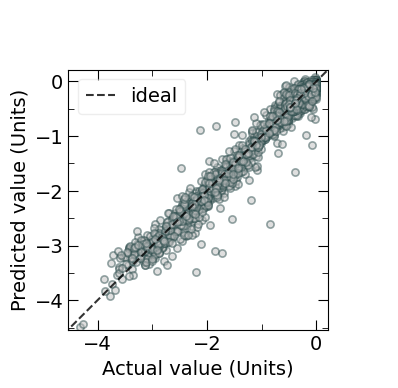

In [36]:
print("Neural Network:")
y_pred = nn_model.predict(X_test)
print('R2: ', nn_model.score(X_test, y_test))  # sklearnrint("MSE: ", mean_squared_error(y_test, model.predict(X_test))) # mse
print("MSE: ", metrics.mean_squared_error(y_test, y_pred))
print("CV: ", cross_validate(nn_model, X, y, cv=5, scoring=('neg_mean_squared_error', 'r2'), n_jobs=-1))  # CV
act_pred(y_test, nn_model.predict(X_test),  x_hist=False, y_hist=False)
#skplt.estimators.plot_feature_importances(rf_model2, feature_names=data.columns[:-1], max_num_features=10, x_tick_rotation=45)
plt.show()

# Saving the model

In [38]:
from sklearn import metrics
from sklearn.model_selection import cross_validate, train_test_split
import scikitplot as skplt
from sklearn.ensemble import RandomForestRegressor
from qin_plot.figures import act_pred
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.utils import shuffle
RNG_SEED = 42
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import pickle


In [55]:
X = data.iloc[:, :-1].to_numpy()
y = data["Ef"].to_numpy()
minmax_scaler = MinMaxScaler().fit(X)
X = minmax_scaler.transform(X)
y = np.where(y < 0, 1, 0)

In [56]:
with open(f"./model/minmax_scaler1.pickle", "wb") as file:
        pickle.dump(minmax_scaler, file)

In [53]:
rf_model = RandomForestClassifier(n_estimators=40, n_jobs=-1, random_state=RNG_SEED)
rf_model.fit(X, y)
nn_model = MLPClassifier(hidden_layer_sizes=(100, 200, 200, 100), random_state=RNG_SEED)
nn_model.fit(X, y)

MLPClassifier(hidden_layer_sizes=(100, 200, 200, 100), random_state=42)

In [54]:

with open(f"./model/rf_classify.pickle", "wb") as file:
        pickle.dump(rf_model, file)
with open(f"./model/nn_classify.pickle", "wb") as file:
        pickle.dump(nn_model, file)


In [57]:
data1 = data[data['Ef']<0]
X = data1.iloc[:, :-1].to_numpy()
y = data1["Ef"].to_numpy()
minmax_scaler = MinMaxScaler().fit(X)
X = minmax_scaler.transform(X)

In [58]:
with open(f"./model/minmax_scaler2.pickle", "wb") as file:
        pickle.dump(minmax_scaler, file)

In [59]:
rf_model = RandomForestRegressor(n_estimators=40, n_jobs=-1, random_state=RNG_SEED)
rf_model.fit(X, y)
nn_model = MLPRegressor(hidden_layer_sizes=(100, 200, 200, 100), random_state=RNG_SEED)
nn_model.fit(X, y)

MLPRegressor(hidden_layer_sizes=(100, 200, 200, 100), random_state=42)

In [60]:
with open(f"./model/rf_regress.pickle", "wb") as file:
        pickle.dump(rf_model, file)
with open(f"./model/nn_regress.pickle", "wb") as file:
        pickle.dump(nn_model, file)